In [1]:
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import oommfc as oc
from tqdm import tqdm

In [2]:
region = df.Region(p1=(-50e-9, -50e-9, 0), p2=(50e-9, 50e-9, 10e-9))
mesh = df.Mesh(region=region, cell=(2.5e-9, 2.5e-9, 2.5e-9))

In [3]:
system = mm.System(name='skyrmion')

system.energy = (mm.Exchange(A=1.6e-11)
               + mm.DMI(D=4e-3, crystalclass='Cnv_z')
               + mm.UniaxialAnisotropy(K=0.51e6, u=(0, 0, 1))
               + mm.Demag()
               + mm.Zeeman(H=(0, 0, 2e5)))
# system.energy = mm.DMI(D=4e-3, crystalclass='Cnv_z')

In [4]:
Ms = 1.1e6

def Ms_fun(pos):
    """Function to set magnitude of magnetisation: zero outside cylindric shape,
    Ms inside cylinder.

    Cylinder radius is 50nm.

    """
    x, y, z = pos
    if (x**2 + y**2)**0.5 < 50e-9:
        return Ms
    else:
        return 0

def m_init(pos):
    """Function to set initial magnetisation direction:
    -z inside cylinder (r=10nm),
    +z outside cylinder.
    y-component to break symmetry.

    """
    x, y, z = pos
    if (x**2 + y**2)**0.5 < 10e-9:
        return (0, 0, -1)
    else:
        return (0, 0, 1)


# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, dim=3, value=m_init, norm=Ms)

In [5]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
# system.m.plane('z').mpl()

Running OOMMF (ExeOOMMFRunner)[2023/08/03 20:29]... (6.5 s)


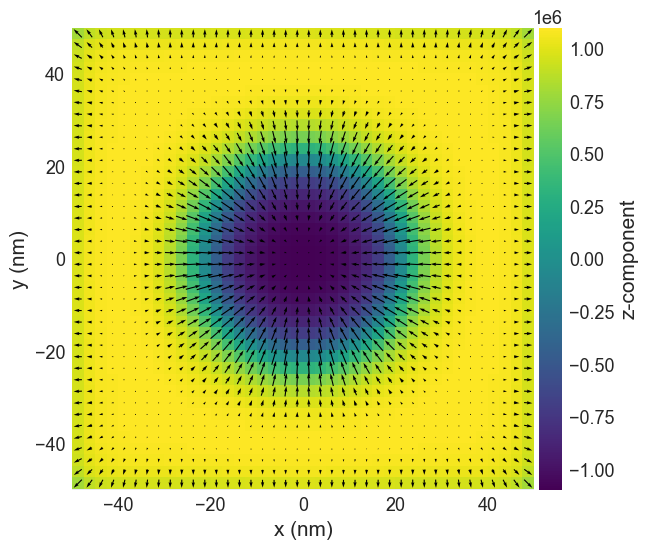

In [6]:
system.m.plane('z').mpl()

In [19]:
def split_into_chunks(field, num_chunks, ghost_size=1):
    chunks = []
    chunk_size = field.shape[0] // num_chunks
    print(chunk_size)
    
    for i in range(num_chunks):
        start = i * chunk_size - ghost_size if i > 0 else 0
        end = (i + 1) * chunk_size + ghost_size if i < num_chunks - 1 else field.shape[0]
        chunks.append(field[start:end])
    return chunks

In [25]:
class MCDriver():
    def __init__(self, system) -> None:
        self.m0 = 4*np.pi*1e-7 # Tm/A
        self.grid = system.m.array
        magnitudes = np.linalg.norm(self.grid, axis=-1)
        magnitudes[magnitudes == 0] = 1 #avoid division by zero
        self.grid = self.grid/magnitudes[..., np.newaxis] #normalise vectors to get m(r)
        self.dx, self.dy, self.dz = system.m.mesh.cell
        self.temperature = system.T + 0.1 #avoid division by zero
        self.Kb = 1.38064852e-23 #Boltzmann constant
        # What about multiple similar energy terms????
        try:
            self.zeeman_K = system.energy.zeeman.H
        except:
            self.zeeman_K = None
        try:
            self.exchange_A =  system.energy.exchange.A
        except:
            self.exchange_A = None
        try:
            self.dmi_D = system.energy.dmi.D
            self.type = system.energy.dmi.crystalclass
        except:
            self.dmi_D = None
        try:
            self.anisotropic_K, self.anisotropic_u = (system.energy.uniaxialanisotropy.K, np.array(system.energy.uniaxialanisotropy.u))
        except:
            self.anisotropic_K, self.anisotropic_u = (None, None)
        try:
            self.demag_N = system.energy.demag.N
        except:
            self.demag_N = None
            
    def zeeman_energy(self):
        if self.zeeman_K is None:
            return 0
        # create a grid shape validation for length of grids shape less than 2 and more than 4 are not supported
        if len(self.grid.shape) < 2 or len(self.grid.shape) > 4:
            raise ValueError("Grid shape is not supported")

        energy = -self.m0*Ms*np.sum(np.dot(self.grid, self.zeeman_K)*self.dx*self.dy*self.dz)
        return energy
    
    def anisotropic_energy(self): # only uniaxial anisotropy is supported
        if self.anisotropic_K is None:
            return 0
        
        energy = np.cross(self.grid, self.anisotropic_u)
        energy = self.anisotropic_K*np.sum(np.sum(energy**2, axis=-1))*self.dx*self.dy*self.dz #total energy of the system

        return energy
    
    def exchange_energy(self):
        if self.exchange_A is None:
            return 0
        # compute the Laplacian
        grid = np.pad(self.grid, ((1, 1), (1, 1), (1, 1), (0, 0)), mode='edge') # 'constant'
        # calculate the laplacian using (f(x + h) + f(x - h) - 2f(x))h^2

        laplacian_M = (((grid[2:, 1:-1, 1:-1] - 2 * grid[1:-1, 1:-1, 1:-1] + grid[:-2, 1:-1, 1:-1])/self.dx**2) + \
                       ((grid[1:-1, 2:, 1:-1] - 2 * grid[1:-1, 1:-1, 1:-1] + grid[1:-1, :-2, 1:-1])/self.dy**2) + \
                       ((grid[1:-1, 1:-1, 2:] - 2 * grid[1:-1, 1:-1, 1:-1] + grid[1:-1, 1:-1, :-2])/self.dz**2)
                    )
                    
        energy = np.sum(self.grid*laplacian_M) #dot product of m and laplacian_M
        energy = -self.exchange_A*energy*self.dx*self.dy*self.dz #total energy of the system
        return energy
    
    def dmi_energy(self):
        if self.dmi_D is None:
            return 0

            
        grid = np.pad(self.grid, ((1, 1), (1, 1), (1, 1), (0, 0)), mode='edge') # 'constant'

        if self.type == 'Cnv_z':
            #calculate gradient of z component of m vector with respect to each axis
            gradM_z = np.empty_like(self.grid, dtype='float64')
            gradM_z[..., 0] = (grid[2:, 1:-1, 1:-1, 2] - grid[:-2, 1:-1, 1:-1, 2]) / (2 * self.dx)
            gradM_z[..., 1] = (grid[1:-1, 2:, 1:-1, 2] - grid[1:-1, :-2, 1:-1, 2]) / (2 * self.dy)
            gradM_z[..., 2] = (grid[1:-1, 1:-1, 2:, 2] - grid[1:-1, 1:-1, :-2, 2]) / (2 * self.dz)


            #divergence of m vector
            div_M = (
                (grid[2:, 1:-1, 1:-1, 0] - grid[:-2, 1:-1, 1:-1, 0]) / (2 * self.dx) +
                (grid[1:-1, 2:, 1:-1, 1] - grid[1:-1, :-2, 1:-1, 1]) / (2 * self.dy) +
                (grid[1:-1, 1:-1, 2:, 2] - grid[1:-1, 1:-1, :-2, 2]) / (2 * self.dz)
                )
            
            m_del_mz = np.sum(self.grid*gradM_z, axis=-1) #dot product of m and gradient of z component of m vector
            mz_div_m = self.grid[..., 2]*div_M  # mz∇⋅m

            energy = self.dmi_D * (np.sum(m_del_mz) - np.sum(mz_div_m)) * self.dx * self.dy * self.dz #Total energy of the system

        return energy
    
    def total_energy(self):
        return self.zeeman_energy() + self.anisotropic_energy() + self.exchange_energy() + self.dmi_energy()
    
    def driver(self, N):

        E_before = self.total_energy()

        for i in range(N):
            # 1. Randomly select a cell
            cell_x = np.random.randint(0, self.grid.shape[0])
            cell_y = np.random.randint(0, self.grid.shape[1])
            cell_z = np.random.randint(0, self.grid.shape[2]) 

            while np.all(self.grid[cell_x , cell_y, cell_z] == 0): #if the cell is empty, select another cell
                cell_x = np.random.randint(0, self.grid.shape[0])
                cell_y = np.random.randint(0, self.grid.shape[1])
                cell_z = np.random.randint(0, self.grid.shape[2])
            # 2Randomly select a direction by introducing some uniform noise to the existing direction

            direction = self.grid[cell_x, cell_y, cell_z] + np.random.normal(-0.1, 0.1, size=3)
            direction = direction/np.linalg.norm(direction) #normalise the direction vector

            #3 Change the direction of the cell
            prev_direction = np.copy(self.grid[cell_x, cell_y, cell_z])
            self.grid[cell_x, cell_y, cell_z] = direction
            
            # 4 Calculate the energy of the system after the change
            E_after = self.zeeman_energy() + self.anisotropic_energy() + self.exchange_energy() + self.dmi_energy()

            # 5 If energy is lower than previous energy, accept the change
            delta_E = E_after - E_before

            if delta_E < 0: #if energy is lower than previous energy, accept the change
                E_before = E_after

            else: #if energy is higher than previous energy, accept the change with probability exp(-dE/kT)
                R = np.exp(-delta_E/(self.Kb*self.temperature))
                if np.random.uniform(0, 1) < R:
                    E_before = E_after

                else:
                    self.grid[cell_x, cell_y, cell_z] = prev_direction #revert the change



        return self.grid

In [ ]:
mc1 = MCDriver()